In [8]:
"""
This script provides a training and evaluation pipeline for both Classical Graph Convolutional Networks (GCN)
and Quantum Graph Neural Networks (QGNN). It's designed to be run locally or within a qBraid Lab
environment, mimicking the parameter passing of a GitHub Actions workflow.

To run this script:
1. Ensure your 'src/synqronix/config.py' and 'src/synqronix/main.py' modules are correctly
   placed in your repository structure.
2. Install all necessary Python dependencies listed in your 'requirements.txt' file
   (e.g., qbraid, torch, dgl, qiskit, etc.).
3. Set your QBRAID_API_KEY environment variable before running the script:
   - Linux/macOS: export QBRAID_API_KEY="YOUR_ACTUAL_QBRAID_API_KEY"
   - Windows (PowerShell): $env:QBRAID_API_KEY="YOUR_ACTUAL_QBRAID_API_KEY"
   - Windows (Command Prompt): set QBRAID_API_KEY="YOUR_ACTUAL_QBRAID_API_KEY"
4. Make sure you have the necessary data files in the specified './data'.
5. Execute the script: python run_training_pipeline.py
"""


'\nThis script provides a training and evaluation pipeline for both Classical Graph Convolutional Networks (GCN)\nand Quantum Graph Neural Networks (QGNN). It\'s designed to be run locally or within a qBraid Lab\nenvironment, mimicking the parameter passing of a GitHub Actions workflow.\n\nTo run this script:\n1. Ensure your \'src/synqronix/config.py\' and \'src/synqronix/main.py\' modules are correctly\n   placed in your repository structure.\n2. Install all necessary Python dependencies listed in your \'requirements.txt\' file\n   (e.g., qbraid, torch, dgl, qiskit, etc.).\n3. Set your QBRAID_API_KEY environment variable before running the script:\n   - Linux/macOS: export QBRAID_API_KEY="YOUR_ACTUAL_QBRAID_API_KEY"\n   - Windows (PowerShell): $env:QBRAID_API_KEY="YOUR_ACTUAL_QBRAID_API_KEY"\n   - Windows (Command Prompt): set QBRAID_API_KEY="YOUR_ACTUAL_QBRAID_API_KEY"\n4. Make sure you have the necessary data files in the specified \'./data\'.\n5. Execute the script: python run_trai

In [9]:
!pip install -r requirements.txt

import os
import sys
import json
import argparse

# --- 1. Setup and Parameter Definition ---

# Ensure the src directory is in the Python path
# This is crucial if you're running the script from the repository root.
if os.path.abspath('src') not in sys.path:
    sys.path.insert(0, os.path.abspath('src'))

# Import your project-specific modules
try:
    from src.synqronix.config import define_parameters
    from src.synqronix.main import main, build_data
except ImportError as e:
    print(f"Error importing synqronix modules: {e}")
    print("Please ensure 'src/synqronix/config.py' and 'src/synqronix/main.py' exist and are accessible.")
    sys.exit(1)

print("Modules loaded successfully.")

Modules loaded successfully.


In [23]:
# --- Define Parameters ---
# These values serve as defaults if not overridden by environment variables.
# For qBraid Lab, you could potentially set these as environment variables
# in your qBraid Lab environment settings if you prefer, or pass them
# as part of a custom startup script if qBraid supports that.

NB_DATA_DIR = os.environ.get("NB_DATA_DIR", "/Users/mariayuffa/Downloads/Auditory cortex data")
NB_SAVE_DIR = os.environ.get("NB_SAVE_DIR", "checkpoints/")
NB_NUM_EPOCHS = int(os.environ.get("NB_NUM_EPOCHS", "50"))
NB_QUANTUM_DEVICE = os.environ.get("NB_QUANTUM_DEVICE", "default")

# The original workflow uses QBRAID_RUN_INPUTS, let's keep that as a fallback/override mechanism
qbraid_run_inputs_str = os.environ.get("QBRAID_RUN_INPUTS", "{}")
try:
    qbraid_run_inputs = json.loads(qbraid_run_inputs_str)
except json.JSONDecodeError:
    print(f"Warning: Could not parse QBRAID_RUN_INPUTS: {qbraid_run_inputs_str}. Using defaults.")
    qbraid_run_inputs = {}

# --- Create an argparse.Namespace object to mimic 'args' ---
# We'll use the define_parameters to get a base parser, then populate args
parser = define_parameters()
args = parser.parse_args([])

# Create an empty namespace to hold our arguments
args = argparse.Namespace()

# Populate with defaults from define_parameters first
# This ensures all expected arguments are present, even if not explicitly defined above.
default_args, _ = parser.parse_known_args([])
for arg_name in vars(default_args):
    setattr(args, arg_name, getattr(default_args, arg_name))

# Override with script-specific parameters (NB_ prefix)
args.data_dir = NB_DATA_DIR
args.save_dir = NB_SAVE_DIR
args.num_epochs = NB_NUM_EPOCHS
args.quantum_device = NB_QUANTUM_DEVICE

# Override with any QBRAID_RUN_INPUTS (highest precedence)
for k, v in qbraid_run_inputs.items():
    # Convert types if necessary, argparse usually handles this. Here we assume string for simplicity
    if k == "num_epochs":
        setattr(args, k, int(v))
    elif k == "hidden_dim": # Assuming hidden_dim might be passed from GH Actions
        setattr(args, k, int(v))
    else:
        setattr(args, k, v)


# Ensure api_key is handled. It's not in workflow_dispatch inputs, but needed for QGNN.
# It should come from the environment where the notebook is run (e.g., qBraid Lab environment variables)
args.api_key = os.environ.get("QBRAID_API_KEY", "x6fixsgqtckrp1c10shd6oiprsi8yr")

print("--- Final Arguments for Pipeline --- ")
for arg_name, arg_value in vars(args).items():
    if arg_name == 'api_key' and arg_value is not None: # Don't print the actual key
        print(f"  {arg_name}: {'****' * 5}")
    else:
        print(f"  {arg_name}: {arg_value}")
print("------------------------------------ ")

--- Final Arguments for Pipeline --- 
  data_dir: /Users/mariayuffa/Downloads/Auditory cortex data
  save_dir: checkpoints/
  model_type: QGCN
  hidden_dim: 64
  num_layers: 3
  dropout_rate: 0.5
  lr: 0.001
  weight_decay: 0.0001
  batch_size: 32
  num_epochs: 50
  k: 20
  connectivity_threshold: 0.5
  add_hyperedges: False
  checkpoint_freq: 5
  resume_from: None
  evaluate_only: None
  seed: 42
  col_width: 50
  col_height: 30
  dataset: functional
  quantum_device: default
  shots: None
  api_key: ********************
  q_depths: [2, 2]
------------------------------------ 


In [19]:
# --- Main Training Pipeline ---
# --- 1. Build Data Loaders and Environment ---
print("\nBuilding data and environment...")
(data_loader, train_loader, val_loader,
test_loader, device, checkpoint_dir, eval_dir) = build_data(args)

print("Data and environment built successfully.")
print(f"Device: {device}")
print(f"Checkpoint Directory: {checkpoint_dir}")
print(f"Evaluation Directory: {eval_dir}")


Building data and environment...
Using device: cpu
Loading and processing data...
Found 9 session files
Processing allPlanesVariables27-Feb-2021.mat
Created 931 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 530 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 605 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 1447 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 1183 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 1180 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Created 459 subgraphs from session
Processing allPlanesVariables27-Feb-2021.mat
Skipping /Users/mariayuffa/Downloads/Auditory cortex data/031120_352ll_100um20st_FRA_diffxy/allPlanesVariables27-Feb-2021.mat because it has dubious values 🤨
Processing allPlanesVariables27-Feb-2021.mat
Created 592 subgraphs from session
Total subgraphs created: 6927
Data split: 4848 tr

/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



--- Starting Training for Model Type: GCN ---
Model created: GCN
Total parameters: 11,593
Starting training...
Starting training for 160 epochs...
Device: cpu
Model parameters: 11,593


Validation: 100%|██████████| 33/33 [00:00<00:00, 153.92it/s]


Epoch   1/160 | Train Loss: 2.1350 | Train Acc: 0.1815 | Val Loss: 2.0228 | Val Acc: 0.2518 | Val F1: 0.1854 | Time: 2.58s


Validation: 100%|██████████| 33/33 [00:00<00:00, 148.87it/s]


Epoch   2/160 | Train Loss: 2.0558 | Train Acc: 0.2229 | Val Loss: 1.9774 | Val Acc: 0.2620 | Val F1: 0.2152 | Time: 3.04s


Validation: 100%|██████████| 33/33 [00:00<00:00, 162.71it/s]


Epoch   3/160 | Train Loss: 2.0293 | Train Acc: 0.2372 | Val Loss: 1.9614 | Val Acc: 0.2755 | Val F1: 0.2240 | Time: 2.87s


Validation: 100%|██████████| 33/33 [00:00<00:00, 152.87it/s]


Epoch   4/160 | Train Loss: 2.0108 | Train Acc: 0.2443 | Val Loss: 1.9394 | Val Acc: 0.2762 | Val F1: 0.2372 | Time: 2.74s


Validation: 100%|██████████| 33/33 [00:00<00:00, 146.57it/s]


New best model saved at epoch 4 with validation accuracy: 0.2817
Epoch   5/160 | Train Loss: 1.9966 | Train Acc: 0.2499 | Val Loss: 1.9315 | Val Acc: 0.2817 | Val F1: 0.2482 | Time: 2.69s


Validation: 100%|██████████| 33/33 [00:00<00:00, 158.38it/s]


Epoch   6/160 | Train Loss: 1.9861 | Train Acc: 0.2538 | Val Loss: 1.9237 | Val Acc: 0.2788 | Val F1: 0.2393 | Time: 2.39s


Validation: 100%|██████████| 33/33 [00:00<00:00, 137.86it/s]


New best model saved at epoch 6 with validation accuracy: 0.2885
Epoch   7/160 | Train Loss: 1.9795 | Train Acc: 0.2567 | Val Loss: 1.9101 | Val Acc: 0.2885 | Val F1: 0.2530 | Time: 2.76s


Validation: 100%|██████████| 33/33 [00:00<00:00, 148.92it/s]


Epoch   8/160 | Train Loss: 1.9686 | Train Acc: 0.2620 | Val Loss: 1.9008 | Val Acc: 0.2866 | Val F1: 0.2454 | Time: 2.53s


Validation: 100%|██████████| 33/33 [00:00<00:00, 151.79it/s]


New best model saved at epoch 8 with validation accuracy: 0.2931
Epoch   9/160 | Train Loss: 1.9631 | Train Acc: 0.2634 | Val Loss: 1.8968 | Val Acc: 0.2931 | Val F1: 0.2528 | Time: 2.79s


Validation: 100%|██████████| 33/33 [00:00<00:00, 165.59it/s]


New best model saved at epoch 9 with validation accuracy: 0.2938
Epoch  10/160 | Train Loss: 1.9611 | Train Acc: 0.2662 | Val Loss: 1.8945 | Val Acc: 0.2938 | Val F1: 0.2522 | Time: 2.39s


Validation: 100%|██████████| 33/33 [00:00<00:00, 112.24it/s]


Epoch  11/160 | Train Loss: 1.9588 | Train Acc: 0.2667 | Val Loss: 1.8893 | Val Acc: 0.2926 | Val F1: 0.2481 | Time: 2.67s


Validation: 100%|██████████| 33/33 [00:00<00:00, 165.11it/s]


New best model saved at epoch 11 with validation accuracy: 0.2973
Epoch  12/160 | Train Loss: 1.9551 | Train Acc: 0.2697 | Val Loss: 1.8844 | Val Acc: 0.2973 | Val F1: 0.2496 | Time: 2.42s


Validation: 100%|██████████| 33/33 [00:00<00:00, 169.98it/s]


Epoch  13/160 | Train Loss: 1.9486 | Train Acc: 0.2706 | Val Loss: 1.8759 | Val Acc: 0.2960 | Val F1: 0.2471 | Time: 2.31s


Validation: 100%|██████████| 33/33 [00:00<00:00, 149.53it/s]


New best model saved at epoch 13 with validation accuracy: 0.3066
Epoch  14/160 | Train Loss: 1.9471 | Train Acc: 0.2730 | Val Loss: 1.8772 | Val Acc: 0.3066 | Val F1: 0.2712 | Time: 2.61s


Validation: 100%|██████████| 33/33 [00:00<00:00, 164.49it/s]


Epoch  15/160 | Train Loss: 1.9385 | Train Acc: 0.2760 | Val Loss: 1.8720 | Val Acc: 0.2979 | Val F1: 0.2566 | Time: 2.41s


Validation: 100%|██████████| 33/33 [00:00<00:00, 152.62it/s]


Epoch  16/160 | Train Loss: 1.9401 | Train Acc: 0.2733 | Val Loss: 1.8692 | Val Acc: 0.3006 | Val F1: 0.2549 | Time: 2.35s


Validation: 100%|██████████| 33/33 [00:00<00:00, 167.30it/s]


Epoch  17/160 | Train Loss: 1.9403 | Train Acc: 0.2729 | Val Loss: 1.8739 | Val Acc: 0.3033 | Val F1: 0.2622 | Time: 2.46s


Validation: 100%|██████████| 33/33 [00:00<00:00, 143.26it/s]


Epoch  18/160 | Train Loss: 1.9389 | Train Acc: 0.2730 | Val Loss: 1.8737 | Val Acc: 0.2917 | Val F1: 0.2399 | Time: 2.53s


Validation: 100%|██████████| 33/33 [00:00<00:00, 156.92it/s]


Epoch  19/160 | Train Loss: 1.9374 | Train Acc: 0.2763 | Val Loss: 1.8632 | Val Acc: 0.2963 | Val F1: 0.2535 | Time: 2.67s


Validation: 100%|██████████| 33/33 [00:00<00:00, 158.90it/s]


New best model saved at epoch 19 with validation accuracy: 0.3123
Epoch  20/160 | Train Loss: 1.9293 | Train Acc: 0.2788 | Val Loss: 1.8570 | Val Acc: 0.3123 | Val F1: 0.2666 | Time: 2.49s


Validation: 100%|██████████| 33/33 [00:00<00:00, 155.65it/s]


Epoch  21/160 | Train Loss: 1.9317 | Train Acc: 0.2775 | Val Loss: 1.8603 | Val Acc: 0.3047 | Val F1: 0.2678 | Time: 2.58s


Validation: 100%|██████████| 33/33 [00:00<00:00, 161.68it/s]


Epoch  22/160 | Train Loss: 1.9329 | Train Acc: 0.2771 | Val Loss: 1.8622 | Val Acc: 0.3016 | Val F1: 0.2587 | Time: 2.67s


Validation: 100%|██████████| 33/33 [00:00<00:00, 138.78it/s]


Epoch  23/160 | Train Loss: 1.9275 | Train Acc: 0.2772 | Val Loss: 1.8605 | Val Acc: 0.3107 | Val F1: 0.2615 | Time: 2.62s


Validation: 100%|██████████| 33/33 [00:00<00:00, 140.64it/s]


New best model saved at epoch 23 with validation accuracy: 0.3133
Epoch  24/160 | Train Loss: 1.9278 | Train Acc: 0.2776 | Val Loss: 1.8574 | Val Acc: 0.3133 | Val F1: 0.2689 | Time: 2.59s


Validation: 100%|██████████| 33/33 [00:00<00:00, 161.70it/s]


Epoch  25/160 | Train Loss: 1.9233 | Train Acc: 0.2800 | Val Loss: 1.8512 | Val Acc: 0.3044 | Val F1: 0.2525 | Time: 2.72s


Validation: 100%|██████████| 33/33 [00:00<00:00, 155.06it/s]


Epoch  26/160 | Train Loss: 1.9192 | Train Acc: 0.2832 | Val Loss: 1.8483 | Val Acc: 0.3033 | Val F1: 0.2624 | Time: 2.64s


Validation: 100%|██████████| 33/33 [00:00<00:00, 148.03it/s]


Epoch  27/160 | Train Loss: 1.9195 | Train Acc: 0.2794 | Val Loss: 1.8444 | Val Acc: 0.3005 | Val F1: 0.2570 | Time: 2.62s


Validation: 100%|██████████| 33/33 [00:00<00:00, 150.55it/s]


Epoch  28/160 | Train Loss: 1.9230 | Train Acc: 0.2788 | Val Loss: 1.8528 | Val Acc: 0.3079 | Val F1: 0.2599 | Time: 2.66s


Validation: 100%|██████████| 33/33 [00:00<00:00, 156.69it/s]


Epoch  29/160 | Train Loss: 1.9179 | Train Acc: 0.2848 | Val Loss: 1.8487 | Val Acc: 0.3060 | Val F1: 0.2666 | Time: 2.43s


Validation: 100%|██████████| 33/33 [00:00<00:00, 147.35it/s]


Epoch  30/160 | Train Loss: 1.9190 | Train Acc: 0.2825 | Val Loss: 1.8470 | Val Acc: 0.3085 | Val F1: 0.2707 | Time: 2.56s


Validation: 100%|██████████| 33/33 [00:00<00:00, 132.97it/s]


Epoch  31/160 | Train Loss: 1.9155 | Train Acc: 0.2820 | Val Loss: 1.8510 | Val Acc: 0.3097 | Val F1: 0.2678 | Time: 2.67s


Validation: 100%|██████████| 33/33 [00:00<00:00, 125.38it/s]


New best model saved at epoch 31 with validation accuracy: 0.3140
Epoch  32/160 | Train Loss: 1.9167 | Train Acc: 0.2827 | Val Loss: 1.8404 | Val Acc: 0.3140 | Val F1: 0.2761 | Time: 2.78s


Validation: 100%|██████████| 33/33 [00:00<00:00, 154.86it/s]


Epoch  33/160 | Train Loss: 1.9116 | Train Acc: 0.2846 | Val Loss: 1.8459 | Val Acc: 0.3115 | Val F1: 0.2707 | Time: 2.49s


Validation: 100%|██████████| 33/33 [00:00<00:00, 153.80it/s]


Epoch  34/160 | Train Loss: 1.9154 | Train Acc: 0.2853 | Val Loss: 1.8450 | Val Acc: 0.3134 | Val F1: 0.2738 | Time: 2.65s


Validation: 100%|██████████| 33/33 [00:00<00:00, 159.08it/s]


New best model saved at epoch 34 with validation accuracy: 0.3172
Epoch  35/160 | Train Loss: 1.9144 | Train Acc: 0.2832 | Val Loss: 1.8421 | Val Acc: 0.3172 | Val F1: 0.2852 | Time: 2.49s


Validation: 100%|██████████| 33/33 [00:00<00:00, 155.47it/s]


New best model saved at epoch 35 with validation accuracy: 0.3185
Epoch  36/160 | Train Loss: 1.9139 | Train Acc: 0.2851 | Val Loss: 1.8445 | Val Acc: 0.3185 | Val F1: 0.2814 | Time: 2.56s


Validation: 100%|██████████| 33/33 [00:00<00:00, 158.47it/s]


Epoch  37/160 | Train Loss: 1.9108 | Train Acc: 0.2860 | Val Loss: 1.8420 | Val Acc: 0.3149 | Val F1: 0.2744 | Time: 2.59s


Validation: 100%|██████████| 33/33 [00:00<00:00, 107.17it/s]


Epoch  38/160 | Train Loss: 1.9054 | Train Acc: 0.2872 | Val Loss: 1.8322 | Val Acc: 0.3150 | Val F1: 0.2747 | Time: 2.64s


Validation: 100%|██████████| 33/33 [00:00<00:00, 140.17it/s]


New best model saved at epoch 38 with validation accuracy: 0.3211
Epoch  39/160 | Train Loss: 1.9110 | Train Acc: 0.2862 | Val Loss: 1.8359 | Val Acc: 0.3211 | Val F1: 0.2799 | Time: 2.58s


Validation: 100%|██████████| 33/33 [00:00<00:00, 141.26it/s]


Epoch  40/160 | Train Loss: 1.9103 | Train Acc: 0.2832 | Val Loss: 1.8432 | Val Acc: 0.3190 | Val F1: 0.2813 | Time: 2.47s


Validation: 100%|██████████| 33/33 [00:00<00:00, 148.48it/s]


Epoch  41/160 | Train Loss: 1.9085 | Train Acc: 0.2886 | Val Loss: 1.8404 | Val Acc: 0.3165 | Val F1: 0.2805 | Time: 2.77s


Validation: 100%|██████████| 33/33 [00:00<00:00, 147.57it/s]


Epoch  42/160 | Train Loss: 1.9019 | Train Acc: 0.2883 | Val Loss: 1.8453 | Val Acc: 0.3183 | Val F1: 0.2822 | Time: 2.56s


Validation: 100%|██████████| 33/33 [00:00<00:00, 161.27it/s]


Epoch  43/160 | Train Loss: 1.9035 | Train Acc: 0.2881 | Val Loss: 1.8336 | Val Acc: 0.3124 | Val F1: 0.2694 | Time: 2.61s


Validation: 100%|██████████| 33/33 [00:00<00:00, 155.78it/s]


Epoch  44/160 | Train Loss: 1.9128 | Train Acc: 0.2855 | Val Loss: 1.8335 | Val Acc: 0.3136 | Val F1: 0.2707 | Time: 2.48s


Validation: 100%|██████████| 33/33 [00:00<00:00, 157.85it/s]


New best model saved at epoch 44 with validation accuracy: 0.3235
Epoch  45/160 | Train Loss: 1.9008 | Train Acc: 0.2853 | Val Loss: 1.8311 | Val Acc: 0.3235 | Val F1: 0.2916 | Time: 2.67s


Validation: 100%|██████████| 33/33 [00:00<00:00, 163.88it/s]


Epoch  46/160 | Train Loss: 1.9021 | Train Acc: 0.2880 | Val Loss: 1.8300 | Val Acc: 0.3209 | Val F1: 0.2843 | Time: 2.44s


Validation: 100%|██████████| 33/33 [00:00<00:00, 146.85it/s]


Epoch  47/160 | Train Loss: 1.9080 | Train Acc: 0.2871 | Val Loss: 1.8335 | Val Acc: 0.3169 | Val F1: 0.2745 | Time: 2.56s


Validation: 100%|██████████| 33/33 [00:00<00:00, 167.71it/s]


Epoch  48/160 | Train Loss: 1.9049 | Train Acc: 0.2859 | Val Loss: 1.8358 | Val Acc: 0.3225 | Val F1: 0.2866 | Time: 2.55s


Validation: 100%|██████████| 33/33 [00:00<00:00, 154.83it/s]


Epoch  49/160 | Train Loss: 1.9023 | Train Acc: 0.2882 | Val Loss: 1.8302 | Val Acc: 0.3145 | Val F1: 0.2779 | Time: 2.64s


Validation: 100%|██████████| 33/33 [00:00<00:00, 169.32it/s]


Epoch  50/160 | Train Loss: 1.8974 | Train Acc: 0.2884 | Val Loss: 1.8279 | Val Acc: 0.3179 | Val F1: 0.2784 | Time: 2.46s


Validation: 100%|██████████| 33/33 [00:00<00:00, 161.99it/s]


Epoch  51/160 | Train Loss: 1.9021 | Train Acc: 0.2900 | Val Loss: 1.8278 | Val Acc: 0.3209 | Val F1: 0.2858 | Time: 2.28s


Validation: 100%|██████████| 33/33 [00:00<00:00, 163.84it/s]


Epoch  52/160 | Train Loss: 1.9032 | Train Acc: 0.2888 | Val Loss: 1.8287 | Val Acc: 0.3148 | Val F1: 0.2739 | Time: 2.34s


Validation: 100%|██████████| 33/33 [00:00<00:00, 163.72it/s]


Epoch  53/160 | Train Loss: 1.8976 | Train Acc: 0.2908 | Val Loss: 1.8347 | Val Acc: 0.3209 | Val F1: 0.2810 | Time: 2.37s


Validation: 100%|██████████| 33/33 [00:00<00:00, 157.24it/s]


Epoch  54/160 | Train Loss: 1.9015 | Train Acc: 0.2878 | Val Loss: 1.8379 | Val Acc: 0.3099 | Val F1: 0.2774 | Time: 2.38s


Validation: 100%|██████████| 33/33 [00:00<00:00, 168.82it/s]


Epoch  55/160 | Train Loss: 1.8997 | Train Acc: 0.2896 | Val Loss: 1.8308 | Val Acc: 0.3183 | Val F1: 0.2791 | Time: 2.37s


Validation: 100%|██████████| 33/33 [00:00<00:00, 151.24it/s]


Epoch  56/160 | Train Loss: 1.8948 | Train Acc: 0.2896 | Val Loss: 1.8262 | Val Acc: 0.3177 | Val F1: 0.2836 | Time: 2.41s


Validation: 100%|██████████| 33/33 [00:00<00:00, 168.27it/s]


New best model saved at epoch 56 with validation accuracy: 0.3268
Epoch  57/160 | Train Loss: 1.8883 | Train Acc: 0.2945 | Val Loss: 1.8335 | Val Acc: 0.3268 | Val F1: 0.2893 | Time: 2.35s


Validation: 100%|██████████| 33/33 [00:00<00:00, 164.69it/s]


Epoch  58/160 | Train Loss: 1.8943 | Train Acc: 0.2919 | Val Loss: 1.8275 | Val Acc: 0.3235 | Val F1: 0.2872 | Time: 2.39s


Validation: 100%|██████████| 33/33 [00:00<00:00, 169.08it/s]


Epoch  59/160 | Train Loss: 1.8886 | Train Acc: 0.2936 | Val Loss: 1.8226 | Val Acc: 0.3166 | Val F1: 0.2809 | Time: 2.39s


Validation: 100%|██████████| 33/33 [00:00<00:00, 163.73it/s]


Epoch  60/160 | Train Loss: 1.8861 | Train Acc: 0.2949 | Val Loss: 1.8210 | Val Acc: 0.3243 | Val F1: 0.2898 | Time: 2.33s


Validation: 100%|██████████| 33/33 [00:00<00:00, 169.12it/s]


Epoch  61/160 | Train Loss: 1.8895 | Train Acc: 0.2919 | Val Loss: 1.8200 | Val Acc: 0.3221 | Val F1: 0.2903 | Time: 2.31s


Validation: 100%|██████████| 33/33 [00:00<00:00, 167.84it/s]


Epoch  62/160 | Train Loss: 1.8862 | Train Acc: 0.2941 | Val Loss: 1.8198 | Val Acc: 0.3260 | Val F1: 0.2937 | Time: 2.41s


Validation: 100%|██████████| 33/33 [00:00<00:00, 152.24it/s]


New best model saved at epoch 62 with validation accuracy: 0.3275
Epoch  63/160 | Train Loss: 1.8889 | Train Acc: 0.2945 | Val Loss: 1.8171 | Val Acc: 0.3275 | Val F1: 0.2947 | Time: 2.49s


Validation: 100%|██████████| 33/33 [00:00<00:00, 167.96it/s]


Epoch  64/160 | Train Loss: 1.8928 | Train Acc: 0.2905 | Val Loss: 1.8204 | Val Acc: 0.3234 | Val F1: 0.2874 | Time: 2.31s


Validation: 100%|██████████| 33/33 [00:00<00:00, 162.19it/s]


Epoch  65/160 | Train Loss: 1.8915 | Train Acc: 0.2944 | Val Loss: 1.8220 | Val Acc: 0.3255 | Val F1: 0.2900 | Time: 2.35s


Validation: 100%|██████████| 33/33 [00:00<00:00, 162.96it/s]


New best model saved at epoch 65 with validation accuracy: 0.3288
Epoch  66/160 | Train Loss: 1.8891 | Train Acc: 0.2948 | Val Loss: 1.8211 | Val Acc: 0.3288 | Val F1: 0.2973 | Time: 2.35s


Validation: 100%|██████████| 33/33 [00:00<00:00, 170.24it/s]


Epoch  67/160 | Train Loss: 1.8844 | Train Acc: 0.2955 | Val Loss: 1.8204 | Val Acc: 0.3242 | Val F1: 0.2876 | Time: 2.27s


Validation: 100%|██████████| 33/33 [00:00<00:00, 162.37it/s]


Epoch  68/160 | Train Loss: 1.8861 | Train Acc: 0.2935 | Val Loss: 1.8159 | Val Acc: 0.3258 | Val F1: 0.2885 | Time: 2.34s


Validation: 100%|██████████| 33/33 [00:00<00:00, 166.57it/s]


Epoch  69/160 | Train Loss: 1.8881 | Train Acc: 0.2951 | Val Loss: 1.8182 | Val Acc: 0.3254 | Val F1: 0.2906 | Time: 2.34s


Validation: 100%|██████████| 33/33 [00:00<00:00, 168.73it/s]


Epoch  70/160 | Train Loss: 1.8859 | Train Acc: 0.2974 | Val Loss: 1.8159 | Val Acc: 0.3226 | Val F1: 0.2906 | Time: 2.26s


Validation: 100%|██████████| 33/33 [00:00<00:00, 161.06it/s]


Epoch  71/160 | Train Loss: 1.8855 | Train Acc: 0.2956 | Val Loss: 1.8179 | Val Acc: 0.3273 | Val F1: 0.2944 | Time: 2.37s


Validation: 100%|██████████| 33/33 [00:00<00:00, 151.71it/s]


Epoch  72/160 | Train Loss: 1.8830 | Train Acc: 0.2961 | Val Loss: 1.8145 | Val Acc: 0.3284 | Val F1: 0.2963 | Time: 2.41s


Validation: 100%|██████████| 33/33 [00:00<00:00, 152.08it/s]


Epoch  73/160 | Train Loss: 1.8839 | Train Acc: 0.2979 | Val Loss: 1.8128 | Val Acc: 0.3267 | Val F1: 0.2931 | Time: 2.70s


Validation: 100%|██████████| 33/33 [00:00<00:00, 147.32it/s]


Epoch  74/160 | Train Loss: 1.8860 | Train Acc: 0.2948 | Val Loss: 1.8171 | Val Acc: 0.3200 | Val F1: 0.2815 | Time: 2.47s


Validation: 100%|██████████| 33/33 [00:00<00:00, 167.32it/s]


Epoch  75/160 | Train Loss: 1.8813 | Train Acc: 0.2978 | Val Loss: 1.8124 | Val Acc: 0.3268 | Val F1: 0.2921 | Time: 2.45s


Validation: 100%|██████████| 33/33 [00:00<00:00, 166.52it/s]


Epoch  76/160 | Train Loss: 1.8827 | Train Acc: 0.2966 | Val Loss: 1.8108 | Val Acc: 0.3250 | Val F1: 0.2902 | Time: 2.38s


Validation: 100%|██████████| 33/33 [00:00<00:00, 141.81it/s]


Epoch  77/160 | Train Loss: 1.8794 | Train Acc: 0.2987 | Val Loss: 1.8172 | Val Acc: 0.3245 | Val F1: 0.2958 | Time: 2.59s


Validation: 100%|██████████| 33/33 [00:00<00:00, 160.03it/s]


Epoch  78/160 | Train Loss: 1.8824 | Train Acc: 0.2957 | Val Loss: 1.8145 | Val Acc: 0.3243 | Val F1: 0.2898 | Time: 2.54s


Validation: 100%|██████████| 33/33 [00:00<00:00, 123.64it/s]


Epoch  79/160 | Train Loss: 1.8770 | Train Acc: 0.2997 | Val Loss: 1.8173 | Val Acc: 0.3284 | Val F1: 0.2937 | Time: 2.46s


Validation: 100%|██████████| 33/33 [00:00<00:00, 162.10it/s]


Epoch  80/160 | Train Loss: 1.8794 | Train Acc: 0.2980 | Val Loss: 1.8152 | Val Acc: 0.3266 | Val F1: 0.2924 | Time: 2.28s


Validation: 100%|██████████| 33/33 [00:00<00:00, 158.19it/s]


Epoch  81/160 | Train Loss: 1.8778 | Train Acc: 0.2982 | Val Loss: 1.8131 | Val Acc: 0.3246 | Val F1: 0.2903 | Time: 2.42s


Validation: 100%|██████████| 33/33 [00:00<00:00, 171.06it/s]


Epoch  82/160 | Train Loss: 1.8824 | Train Acc: 0.2983 | Val Loss: 1.8087 | Val Acc: 0.3253 | Val F1: 0.2974 | Time: 2.62s


Validation: 100%|██████████| 33/33 [00:00<00:00, 166.84it/s]


Epoch  83/160 | Train Loss: 1.8792 | Train Acc: 0.2975 | Val Loss: 1.8112 | Val Acc: 0.3272 | Val F1: 0.2918 | Time: 2.51s


Validation: 100%|██████████| 33/33 [00:00<00:00, 162.11it/s]


Epoch  84/160 | Train Loss: 1.8777 | Train Acc: 0.2993 | Val Loss: 1.8111 | Val Acc: 0.3261 | Val F1: 0.2925 | Time: 2.39s


Validation: 100%|██████████| 33/33 [00:00<00:00, 134.71it/s]


Epoch  85/160 | Train Loss: 1.8852 | Train Acc: 0.2946 | Val Loss: 1.8123 | Val Acc: 0.3252 | Val F1: 0.2897 | Time: 2.45s


Validation: 100%|██████████| 33/33 [00:00<00:00, 166.33it/s]


Epoch  86/160 | Train Loss: 1.8703 | Train Acc: 0.3030 | Val Loss: 1.8088 | Val Acc: 0.3282 | Val F1: 0.2970 | Time: 2.56s


Validation: 100%|██████████| 33/33 [00:00<00:00, 159.23it/s]


Epoch  87/160 | Train Loss: 1.8802 | Train Acc: 0.2970 | Val Loss: 1.8092 | Val Acc: 0.3264 | Val F1: 0.2942 | Time: 2.39s


Validation: 100%|██████████| 33/33 [00:00<00:00, 140.35it/s]


Epoch  88/160 | Train Loss: 1.8804 | Train Acc: 0.2964 | Val Loss: 1.8101 | Val Acc: 0.3275 | Val F1: 0.2953 | Time: 2.50s


Validation: 100%|██████████| 33/33 [00:00<00:00, 161.65it/s]


Epoch  89/160 | Train Loss: 1.8769 | Train Acc: 0.2985 | Val Loss: 1.8160 | Val Acc: 0.3260 | Val F1: 0.2947 | Time: 2.58s


Validation: 100%|██████████| 33/33 [00:00<00:00, 163.71it/s]


Epoch  90/160 | Train Loss: 1.8719 | Train Acc: 0.3003 | Val Loss: 1.8114 | Val Acc: 0.3220 | Val F1: 0.2889 | Time: 2.65s


Validation: 100%|██████████| 33/33 [00:00<00:00, 165.97it/s]


Epoch  91/160 | Train Loss: 1.8786 | Train Acc: 0.2970 | Val Loss: 1.8100 | Val Acc: 0.3252 | Val F1: 0.2916 | Time: 2.52s


Validation: 100%|██████████| 33/33 [00:00<00:00, 159.61it/s]


Epoch  92/160 | Train Loss: 1.8753 | Train Acc: 0.3007 | Val Loss: 1.8133 | Val Acc: 0.3258 | Val F1: 0.2953 | Time: 2.38s
Early stopping at epoch 92

Training completed!
Best validation accuracy: 0.3288 at epoch 66


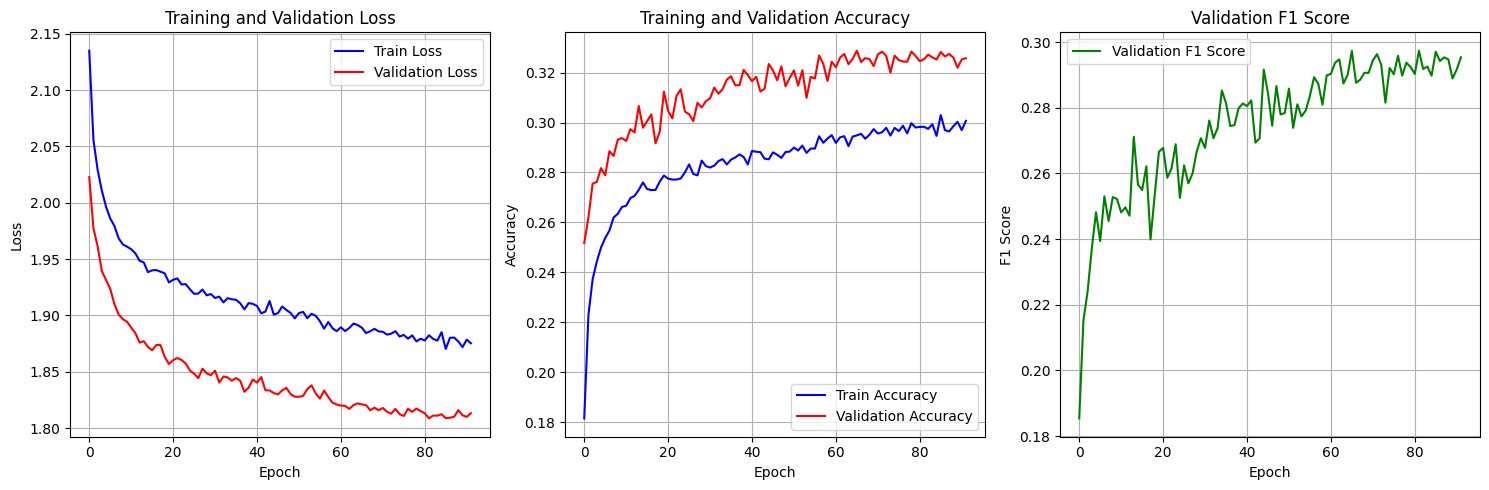


Loading best model for final evaluation...
Performing final evaluation on test set...
Starting comprehensive evaluation...


Evaluating: 100%|██████████| 33/33 [00:00<00:00, 148.97it/s]



Evaluation Metrics:
----------------------------------------
Accuracy: 0.3154
F1_score: 0.2856
F1_macro: 0.2572
F1_micro: 0.3154
Precision: 0.4004
Recall: 0.3154
Roc_auc: 0.7525
Loss: 1.8290

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        BF_1       0.26      0.22      0.24      2759
        BF_2       0.26      0.21      0.24      2044
        BF_3       0.24      0.62      0.34      2933
        BF_4       0.38      0.57      0.45      3872
        BF_5       0.53      0.18      0.27      2153
        BF_6       0.84      0.02      0.05      1762
        BF_7       0.42      0.07      0.11      1595
        BF_8       0.30      0.18      0.22      1419
        BF_9       0.54      0.32      0.40      2239

    accuracy                           0.32     20776
   macro avg       0.42      0.26      0.26     20776
weighted avg       0.40      0.32      0.29     20776



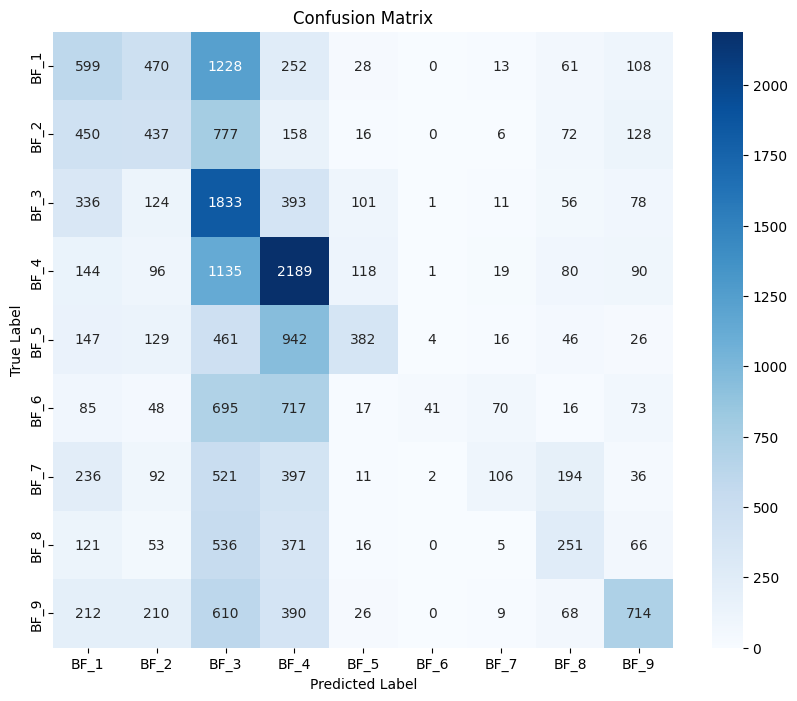

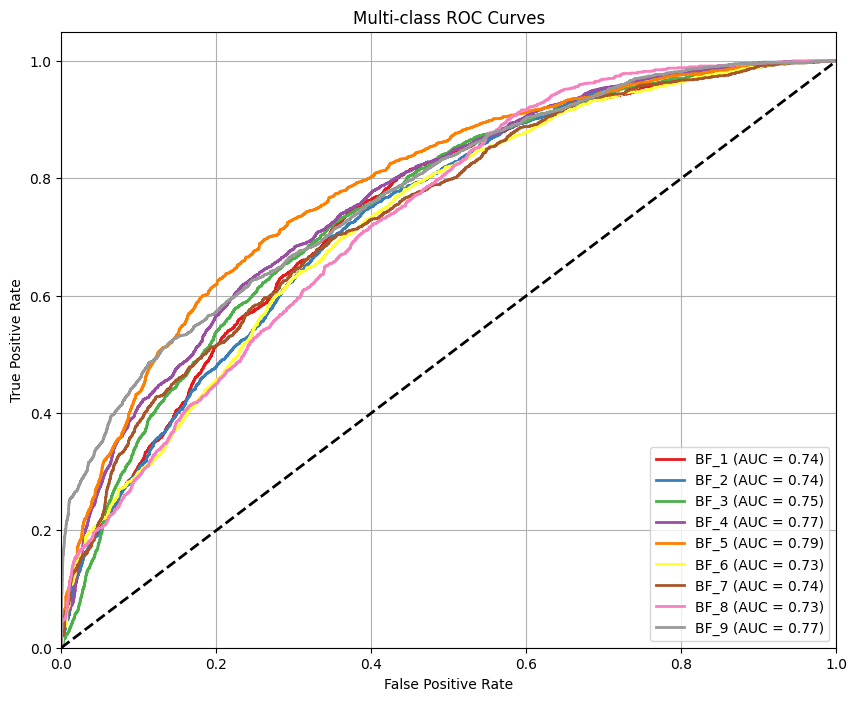

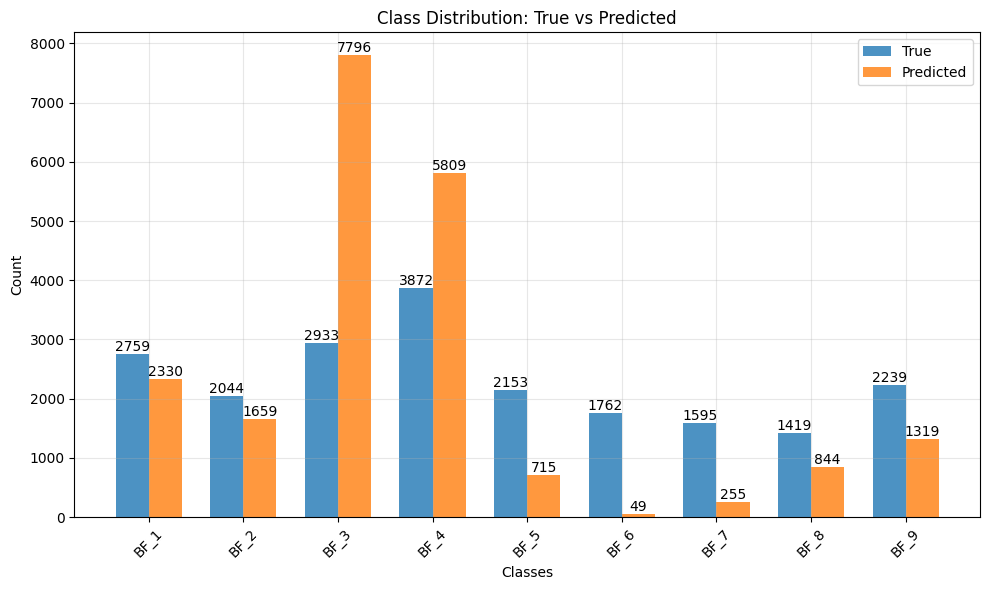


Training completed!
Results saved in: checkpoints/
Best validation accuracy: 0.3288
Final test accuracy: 0.3154
Final test F1 score: 0.2856
Final test ROC AUC: 0.7525
Training of GCN completed successfully!


In [22]:
# Comparison between the two models:
# --- 2. Train Classical GCN Model ---
print("\n--- Starting Training for Model Type: GCN ---")
args.model_type = "GCN" # Ensure model_type is set for GCN
args.num_epochs = 160  # Default epochs for GCN
main(args, data_loader, train_loader,
     val_loader, test_loader, device,
     checkpoint_dir, eval_dir)
print("Training of GCN completed successfully!")

Epoch  15/50 | Train Loss: 2.0811 | Train Acc: 0.2034 | Val Loss: 2.0755 | Val Acc: 0.2135 | Val F1: 0.1587 


--- Starting Training for Model Type: QGNN ---
Model created: QGCN
Total parameters: 1,279
Starting training...
Starting training for 50 epochs...
Device: cpu
Model parameters: 1,279


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.79it/s]


Epoch   1/50 | Train Loss: 2.1921 | Train Acc: 0.1565 | Val Loss: 2.1327 | Val Acc: 0.1789 | Val F1: 0.0556 | Time: 48.11s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.78it/s]


Epoch   2/50 | Train Loss: 2.1428 | Train Acc: 0.1780 | Val Loss: 2.1180 | Val Acc: 0.1849 | Val F1: 0.0860 | Time: 49.50s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.46it/s]


Epoch   3/50 | Train Loss: 2.1283 | Train Acc: 0.1826 | Val Loss: 2.1076 | Val Acc: 0.1961 | Val F1: 0.1196 | Time: 47.64s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.39it/s]


Epoch   4/50 | Train Loss: 2.1201 | Train Acc: 0.1850 | Val Loss: 2.1024 | Val Acc: 0.1931 | Val F1: 0.1181 | Time: 49.21s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.72it/s]


Epoch   5/50 | Train Loss: 2.1087 | Train Acc: 0.1906 | Val Loss: 2.0902 | Val Acc: 0.1949 | Val F1: 0.1344 | Time: 49.91s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.37it/s]


Epoch   6/50 | Train Loss: 2.1006 | Train Acc: 0.1943 | Val Loss: 2.0885 | Val Acc: 0.1964 | Val F1: 0.1440 | Time: 48.85s


Validation: 100%|██████████| 33/33 [00:04<00:00,  8.10it/s]


New best model saved at epoch 6 with validation accuracy: 0.1977
Epoch   7/50 | Train Loss: 2.0961 | Train Acc: 0.1982 | Val Loss: 2.0864 | Val Acc: 0.1977 | Val F1: 0.1326 | Time: 54.23s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.37it/s]


New best model saved at epoch 7 with validation accuracy: 0.2078
Epoch   8/50 | Train Loss: 2.0886 | Train Acc: 0.1994 | Val Loss: 2.0818 | Val Acc: 0.2078 | Val F1: 0.1633 | Time: 55.40s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.22it/s]


Epoch   9/50 | Train Loss: 2.0862 | Train Acc: 0.2007 | Val Loss: 2.0755 | Val Acc: 0.2020 | Val F1: 0.1558 | Time: 51.34s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.13it/s]


New best model saved at epoch 9 with validation accuracy: 0.2108
Epoch  10/50 | Train Loss: 2.0799 | Train Acc: 0.2035 | Val Loss: 2.0774 | Val Acc: 0.2108 | Val F1: 0.1616 | Time: 48.11s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.97it/s]


New best model saved at epoch 10 with validation accuracy: 0.2112
Epoch  11/50 | Train Loss: 2.0803 | Train Acc: 0.2043 | Val Loss: 2.0802 | Val Acc: 0.2112 | Val F1: 0.1599 | Time: 47.20s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.85it/s]


New best model saved at epoch 11 with validation accuracy: 0.2144
Epoch  12/50 | Train Loss: 2.0752 | Train Acc: 0.2075 | Val Loss: 2.0728 | Val Acc: 0.2144 | Val F1: 0.1656 | Time: 47.79s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.87it/s]


New best model saved at epoch 12 with validation accuracy: 0.2171
Epoch  13/50 | Train Loss: 2.0772 | Train Acc: 0.2087 | Val Loss: 2.0743 | Val Acc: 0.2171 | Val F1: 0.1696 | Time: 50.76s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.27it/s]


New best model saved at epoch 13 with validation accuracy: 0.2180
Epoch  14/50 | Train Loss: 2.0712 | Train Acc: 0.2105 | Val Loss: 2.0675 | Val Acc: 0.2180 | Val F1: 0.1693 | Time: 48.31s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.37it/s]


Epoch  15/50 | Train Loss: 2.0699 | Train Acc: 0.2088 | Val Loss: 2.0670 | Val Acc: 0.2143 | Val F1: 0.1694 | Time: 48.99s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.18it/s]


Epoch  16/50 | Train Loss: 2.0669 | Train Acc: 0.2131 | Val Loss: 2.0620 | Val Acc: 0.2146 | Val F1: 0.1676 | Time: 49.02s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.06it/s]


Epoch  17/50 | Train Loss: 2.0663 | Train Acc: 0.2108 | Val Loss: 2.0627 | Val Acc: 0.2101 | Val F1: 0.1634 | Time: 47.89s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.60it/s]


New best model saved at epoch 17 with validation accuracy: 0.2204
Epoch  18/50 | Train Loss: 2.0650 | Train Acc: 0.2134 | Val Loss: 2.0604 | Val Acc: 0.2204 | Val F1: 0.1695 | Time: 48.77s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.20it/s]


Epoch  19/50 | Train Loss: 2.0618 | Train Acc: 0.2143 | Val Loss: 2.0634 | Val Acc: 0.2173 | Val F1: 0.1713 | Time: 49.68s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.33it/s]


Epoch  20/50 | Train Loss: 2.0634 | Train Acc: 0.2154 | Val Loss: 2.0566 | Val Acc: 0.2172 | Val F1: 0.1743 | Time: 48.56s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.91it/s]


New best model saved at epoch 20 with validation accuracy: 0.2210
Epoch  21/50 | Train Loss: 2.0595 | Train Acc: 0.2165 | Val Loss: 2.0593 | Val Acc: 0.2210 | Val F1: 0.1746 | Time: 46.78s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.49it/s]


New best model saved at epoch 21 with validation accuracy: 0.2262
Epoch  22/50 | Train Loss: 2.0614 | Train Acc: 0.2172 | Val Loss: 2.0526 | Val Acc: 0.2262 | Val F1: 0.1816 | Time: 49.45s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.05it/s]


Epoch  23/50 | Train Loss: 2.0569 | Train Acc: 0.2175 | Val Loss: 2.0497 | Val Acc: 0.2240 | Val F1: 0.1755 | Time: 47.58s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.28it/s]


Epoch  24/50 | Train Loss: 2.0522 | Train Acc: 0.2205 | Val Loss: 2.0495 | Val Acc: 0.2225 | Val F1: 0.1727 | Time: 49.24s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.91it/s]


Epoch  25/50 | Train Loss: 2.0514 | Train Acc: 0.2206 | Val Loss: 2.0451 | Val Acc: 0.2210 | Val F1: 0.1764 | Time: 48.81s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.46it/s]


Epoch  26/50 | Train Loss: 2.0511 | Train Acc: 0.2224 | Val Loss: 2.0452 | Val Acc: 0.2140 | Val F1: 0.1658 | Time: 47.99s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.40it/s]


Epoch  27/50 | Train Loss: 2.0483 | Train Acc: 0.2228 | Val Loss: 2.0412 | Val Acc: 0.2251 | Val F1: 0.1765 | Time: 47.64s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.58it/s]


Epoch  28/50 | Train Loss: 2.0464 | Train Acc: 0.2217 | Val Loss: 2.0371 | Val Acc: 0.2173 | Val F1: 0.1751 | Time: 47.23s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.49it/s]


Epoch  29/50 | Train Loss: 2.0443 | Train Acc: 0.2232 | Val Loss: 2.0353 | Val Acc: 0.2206 | Val F1: 0.1807 | Time: 49.33s


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.00it/s]


Epoch  30/50 | Train Loss: 2.0420 | Train Acc: 0.2250 | Val Loss: 2.0379 | Val Acc: 0.2187 | Val F1: 0.1769 | Time: 47.69s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.01it/s]


Epoch  31/50 | Train Loss: 2.0429 | Train Acc: 0.2223 | Val Loss: 2.0385 | Val Acc: 0.2192 | Val F1: 0.1724 | Time: 50.88s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.89it/s]


Epoch  32/50 | Train Loss: 2.0392 | Train Acc: 0.2248 | Val Loss: 2.0362 | Val Acc: 0.2215 | Val F1: 0.1768 | Time: 48.67s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.89it/s]


Epoch  33/50 | Train Loss: 2.0391 | Train Acc: 0.2260 | Val Loss: 2.0334 | Val Acc: 0.2162 | Val F1: 0.1773 | Time: 53.61s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.76it/s]


Epoch  34/50 | Train Loss: 2.0344 | Train Acc: 0.2268 | Val Loss: 2.0308 | Val Acc: 0.2195 | Val F1: 0.1815 | Time: 51.37s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.35it/s]


Epoch  35/50 | Train Loss: 2.0315 | Train Acc: 0.2273 | Val Loss: 2.0296 | Val Acc: 0.2201 | Val F1: 0.1791 | Time: 49.29s


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.25it/s]


Epoch  36/50 | Train Loss: 2.0304 | Train Acc: 0.2282 | Val Loss: 2.0299 | Val Acc: 0.2206 | Val F1: 0.1828 | Time: 47.15s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.33it/s]


Epoch  37/50 | Train Loss: 2.0314 | Train Acc: 0.2279 | Val Loss: 2.0326 | Val Acc: 0.2155 | Val F1: 0.1764 | Time: 49.42s


Validation: 100%|██████████| 33/33 [00:03<00:00,  9.48it/s]


Epoch  38/50 | Train Loss: 2.0284 | Train Acc: 0.2287 | Val Loss: 2.0335 | Val Acc: 0.2126 | Val F1: 0.1718 | Time: 50.51s


Validation: 100%|██████████| 33/33 [00:03<00:00,  8.74it/s]


Epoch  39/50 | Train Loss: 2.0297 | Train Acc: 0.2277 | Val Loss: 2.0297 | Val Acc: 0.2157 | Val F1: 0.1747 | Time: 52.44s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.83it/s]


Epoch  40/50 | Train Loss: 2.0283 | Train Acc: 0.2300 | Val Loss: 2.0308 | Val Acc: 0.2151 | Val F1: 0.1749 | Time: 55.49s


Validation: 100%|██████████| 33/33 [00:04<00:00,  8.01it/s]


Epoch  41/50 | Train Loss: 2.0278 | Train Acc: 0.2290 | Val Loss: 2.0294 | Val Acc: 0.2160 | Val F1: 0.1759 | Time: 54.40s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.79it/s]


Epoch  42/50 | Train Loss: 2.0263 | Train Acc: 0.2268 | Val Loss: 2.0343 | Val Acc: 0.2173 | Val F1: 0.1719 | Time: 55.25s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.06it/s]


Epoch  43/50 | Train Loss: 2.0264 | Train Acc: 0.2294 | Val Loss: 2.0280 | Val Acc: 0.2165 | Val F1: 0.1782 | Time: 63.96s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.59it/s]


Epoch  44/50 | Train Loss: 2.0256 | Train Acc: 0.2298 | Val Loss: 2.0316 | Val Acc: 0.2212 | Val F1: 0.1771 | Time: 71.93s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.58it/s]


Epoch  45/50 | Train Loss: 2.0234 | Train Acc: 0.2313 | Val Loss: 2.0276 | Val Acc: 0.2145 | Val F1: 0.1742 | Time: 60.33s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.34it/s]


Epoch  46/50 | Train Loss: 2.0219 | Train Acc: 0.2318 | Val Loss: 2.0258 | Val Acc: 0.2198 | Val F1: 0.1793 | Time: 62.68s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.33it/s]


Epoch  47/50 | Train Loss: 2.0226 | Train Acc: 0.2316 | Val Loss: 2.0272 | Val Acc: 0.2176 | Val F1: 0.1787 | Time: 66.17s


Validation: 100%|██████████| 33/33 [00:04<00:00,  7.79it/s]


Epoch  48/50 | Train Loss: 2.0222 | Train Acc: 0.2307 | Val Loss: 2.0282 | Val Acc: 0.2179 | Val F1: 0.1758 | Time: 69.95s
Early stopping at epoch 48

Training completed!
Best validation accuracy: 0.2262 at epoch 22


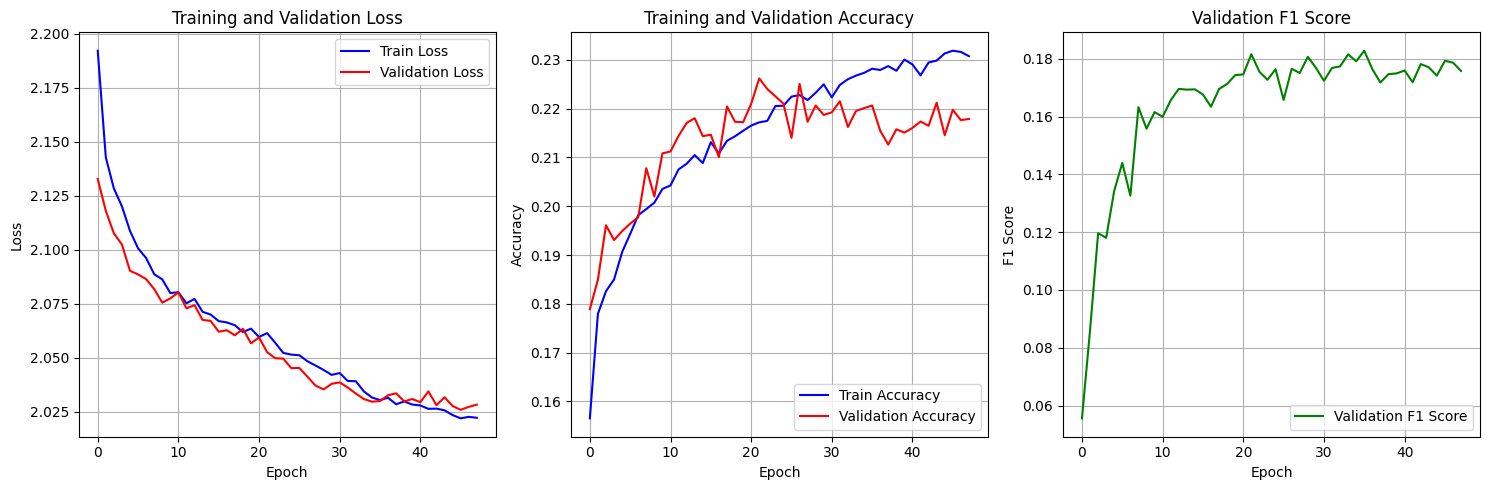


Loading best model for final evaluation...
Performing final evaluation on test set...
Starting comprehensive evaluation...


Evaluating: 100%|██████████| 33/33 [00:04<00:00,  7.89it/s]
/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mariayuffa/synqronix/synqronix/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter


Evaluation Metrics:
----------------------------------------
Accuracy: 0.1753
F1_score: 0.1004
F1_macro: 0.0712
F1_micro: 0.1753
Precision: 0.1080
Recall: 0.1753
Roc_auc: 0.5385
Loss: 2.1587

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        BF_1       0.14      0.08      0.10      2759
        BF_2       0.00      0.00      0.00      2044
        BF_3       0.14      0.19      0.16      2933
        BF_4       0.19      0.72      0.30      3872
        BF_5       0.14      0.03      0.05      2153
        BF_6       0.00      0.00      0.00      1762
        BF_7       0.00      0.00      0.00      1595
        BF_8       0.06      0.00      0.01      1419
        BF_9       0.13      0.01      0.02      2239

    accuracy                           0.18     20776
   macro avg       0.09      0.11      0.07     20776
weighted avg       0.11      0.18      0.10     20776



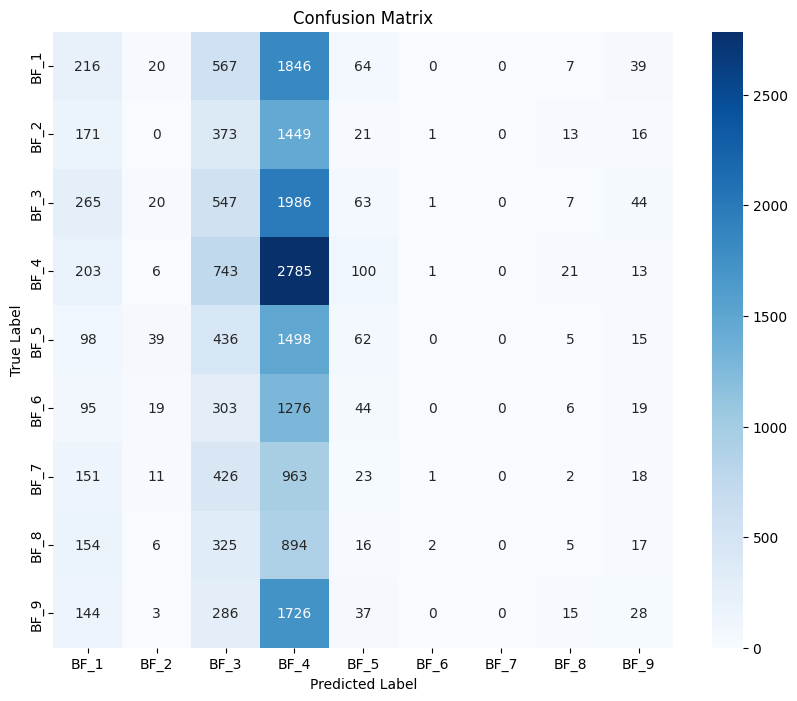

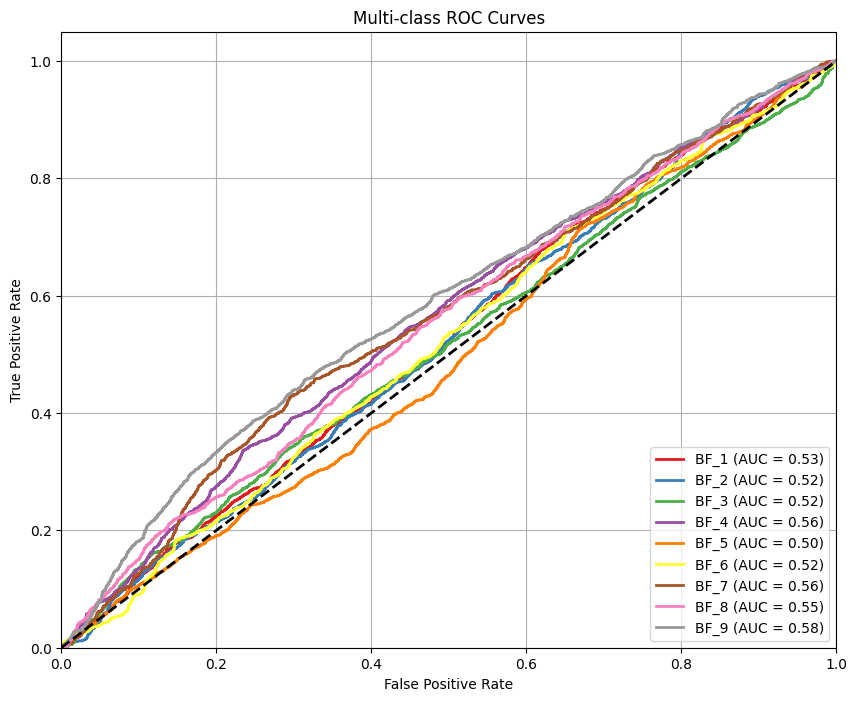

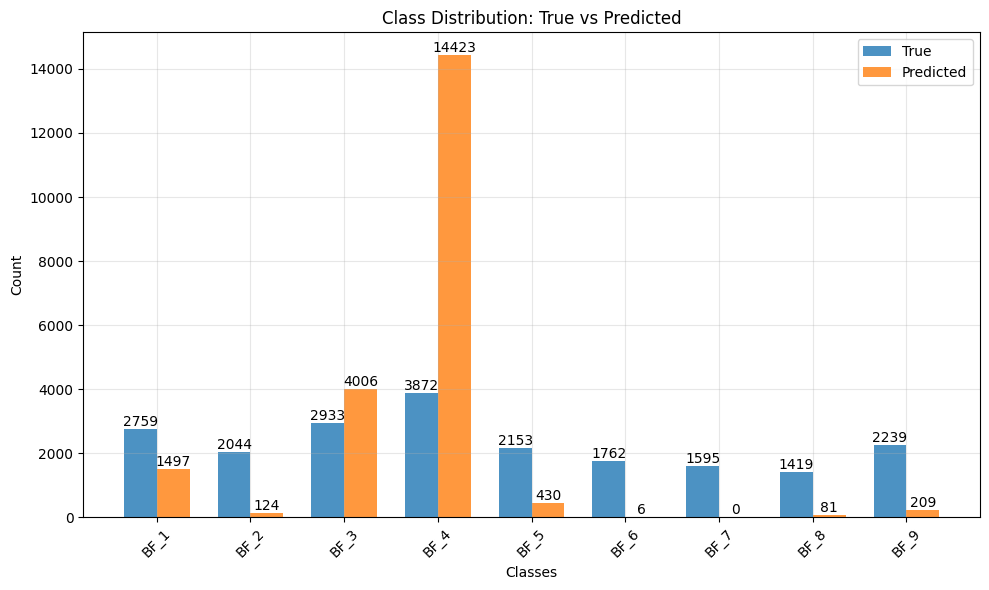


Training completed!
Results saved in: checkpoints/
Best validation accuracy: 0.1989
Final test accuracy: 0.1753
Final test F1 score: 0.1004
Final test ROC AUC: 0.5385
Training of QGCN completed successfully!

Both GCN and QGCN training pipelines have completed. Check your specified 'save_dir' and 'eval_dir' for results.


In [24]:
# --- 3. Train Quantum GNN Model (QGNN) ---
print("\n--- Starting Training for Model Type: QGNN ---")
args.model_type = "QGCN" # Ensure model_type is set for QGNN
args.num_epochs = 50  # Default epochs for QGNN
if not args.api_key:
     raise ValueError("QBRAID_API_KEY environment variable is not set. Please set it in your environment to run QGNN.")

main(args, data_loader, train_loader,
     val_loader, test_loader, device,
     checkpoint_dir, eval_dir)

print("Training of QGCN completed successfully!")

# --- 5. Conclusion ---
print("\nBoth GCN and QGCN training pipelines have completed. Check your specified 'save_dir' and 'eval_dir' for results.")

